# Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import pickle
import random
from collections import deque
import copy
import ast
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet152V2, ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, LSTM, TimeDistributed, Conv2D, Flatten, Dropout, Conv3D, Input, MaxPool3D, Reshape, BatchNormalization, Lambda, RepeatVector, MaxPool2D
from keras.layers.experimental.preprocessing import Rescaling
from keras.models import Model
from keras import preprocessing
from keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_50
from PIL import Image
from keras.optimizers import Adam, RMSprop

In [ ]:
data_dir = '../input/carlahighwaydata-multi-trajectory'

In [ ]:
'''
Acknowledgements/Citations:

Data Augmentations are inspired by:
    Title: Teaching Cars To Drive Using Deep Learning - Steering Angle Prediction
    Author: Eddie Forson
    Date: Sep 16, 2017
    Availability: https://towardsdatascience.com/teaching-cars-to-drive-using-deep-learning-steering-angle-prediction-5773154608f2
    
PilotNet Model draws from: 
    Title: Explaining How a Deep Neural Network Trained with End-to-End Learning Steers a Car
    Authors: Mariusz Bojarski et al.
    Date: April 25, 2017
    Availability: https://arxiv.org/pdf/1704.07911.pdf
    
Encoder-Decoder Model draws from: 
    Title: An LSTM-Based Autonomous Drivng Model Using a Waymo Open Dataset
    Author: Gu, Zhicheng, et al
    Date: March 18, 2020
    Availability: https://www.mdpi.com/2076-3417/10/6/2046/htm#B15-applsci-10-02046
    
Transfer Model is an implementation of: 
    Title: Self-Driving Car Steering Angle Prediction Based on Image Recognition
    Author: Du, Shuyan et al. 
    Date: 2017
    Availability: http://cs231n.stanford.edu/reports/2017/pdfs/626.pdf
'''

# Data Preperation

We organize the data so that it can be input to the model. This takes into consideration the number of frames being used for prediction and how many points we are predicting. The filegenerator function reads the csv file for our dataset and manipulates it according to the observed/predicting frame number. 

Additionally, the dataset is split into train and validation sets so we can verify the performance of the model while training. 

Included in this section is a visualization of the augmentations that we apply to the dataset. This is necessary to make the model generalize better. Adding this is especially important in our case because we have a relatively small dataset of about 4000 datapoints. 
The augmentations we applied are:
* Flipping - horizontal flip is applied as the majority of the dataset consists of right turns. By applying flips to the image and corresponding labels we can have equal distribution of each. 
* Blurring - image blur is applied to generalize the data. The data from the simulator has no movement blur so this produces that more closely resemble real world situations.
* Random Shadow - random shadows are added to the images which also produces more realistic results as the simulator has shifting clouds/shadows so by randomly generating more a more generalized dataset in produced.
* Brightness Adjustment - Similar to adding random shadows, we can apply a brightening effect to the images that cover the whole image.


In [ ]:
observed_frame_num = 3 #number of images to use as input
predicting_frame_num = 1 #number of labels to use. For these models only 1 is required as each frame has a list of trajectories as the label

In [ ]:
def dataframegenerator(csv_file,folder,observed_frame_num,predicting_frame_num): #generates dataframe from saved data, corresponding to the observed_frame_num and predicting_frame_num
    temp_df = pd.read_csv(os.path.join(data_dir,csv_file))
    labels = list(temp_df.trajectory)
    img_list = list(temp_df.filename)
    image_deque = deque()
    label_deque = deque()
    temporal_data = []
    for i in range(temp_df.shape[0] - predicting_frame_num - 1 ):
        img_path = img_list[i][109:]
        image_deque.append(os.path.join(folder,img_path))
        label_deque.append(labels[i+predicting_frame_num - 1])
        if len(label_deque) > predicting_frame_num :
            label_deque.popleft()
        if len(image_deque) == observed_frame_num :
            imgs = copy.deepcopy(image_deque)
            image_deque.popleft()
            if len(label_deque) == predicting_frame_num:
                temporal_data.append((list(imgs),list(copy.deepcopy(label_deque))))

    return pd.DataFrame(temporal_data,columns = ('images','labels'))

In [ ]:
def from_np_array(array_string): #converts array saved in excel to np array
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [ ]:
df = dataframegenerator('driving_data.csv','Images',observed_frame_num,predicting_frame_num)
df.labels = [np.around(from_np_array(x[0])[:11,1], 3) for x in df.labels] #only use current position and 10 points in front as trajectory. This can be adjusted if using the vehicle at higher speeds than needed for this project
df

,images,labels
0,"[Images/100.jpeg, Images/101.jpeg, Images/102....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
1,"[Images/101.jpeg, Images/102.jpeg, Images/103....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
2,"[Images/102.jpeg, Images/103.jpeg, Images/104....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
3,"[Images/103.jpeg, Images/104.jpeg, Images/105....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
4,"[Images/104.jpeg, Images/105.jpeg, Images/106....","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
...,...,...
3992,"[Images/4092.jpeg, Images/4093.jpeg, Images/40...","[0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0,..."
3993,"[Images/4093.jpeg, Images/4094.jpeg, Images/40...","[0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0..."
3994,"[Images/4094.jpeg, Images/4095.jpeg, Images/40...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."
3995,"[Images/4095.jpeg, Images/4096.jpeg, Images/40...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...."


In [ ]:
#augmentations
def flip_image(img):
    return cv2.flip(img,1).astype(np.uint8)

def blur_image(img,f_size=5):
    img = cv2.GaussianBlur(img,(f_size,f_size),0)
    img = np.clip(img,0,255)
    return img.astype(np.uint8)

def add_random_shadow(img, w_low=0.6, w_high=0.85):
    cols, rows = (img.shape[0], img.shape[1])
    top_y = np.random.random_sample() * rows
    bottom_y = np.random.random_sample() * rows
    bottom_y_right = bottom_y + np.random.random_sample() * (rows - bottom_y)
    top_y_right = top_y + np.random.random_sample() * (rows - top_y)
    if np.random.random_sample() <= 0.5:
        bottom_y_right = bottom_y - np.random.random_sample() * (bottom_y)
        top_y_right = top_y - np.random.random_sample() * (top_y)
    poly = np.asarray([[ [top_y,0], [bottom_y, cols], [bottom_y_right, cols], [top_y_right,0]]], dtype=np.int32)
    mask_weight = np.random.uniform(w_low, w_high)
    origin_weight = 1 - mask_weight
    mask = np.copy(img).astype(np.int32)
    cv2.fillPoly(mask, poly, (0, 0, 0))
    return cv2.addWeighted(img.astype(np.int32), origin_weight, mask, mask_weight, 0).astype(np.uint8)

def change_image_brightness_rgb(img, s):
    img = img.astype(np.float32)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

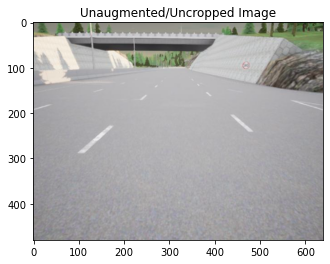

In [ ]:
plt.imshow(cv2.imread(os.path.join(data_dir,df.images.iloc[0][0])))
plt.title('Unaugmented/Uncropped Image')
plt.show()

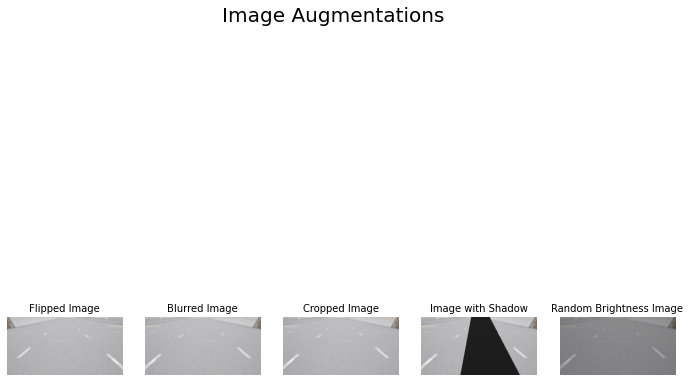

In [13]:
#visualize
base_image = cv2.imread(os.path.join(data_dir,df.images.iloc[0][0]))
reduced_image = base_image[100:300,120:520]

flipped_image = flip_image(reduced_image)
blurred_image = blur_image(reduced_image)
shadow_image = add_random_shadow(reduced_image)
bright_image = change_image_brightness_rgb(reduced_image, np.random.uniform(.7,.75))

w , h = 10, 10
nrows, ncols = 1 , 5
figsize = [h,w]
fig, axs  = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.tight_layout()

axs[0].imshow(flipped_image)
axs[0].set_title('Flipped Image', fontsize=10)
axs[0].axis('off')

axs[1].imshow(blurred_image)
axs[1].set_title('Blurred Image', fontsize=10)
axs[1].axis('off')

axs[2].imshow(reduced_image)
axs[2].set_title('Cropped Image', fontsize=10)
axs[2].axis('off')

axs[3].imshow(shadow_image)
axs[3].set_title('Image with Shadow', fontsize=10)
axs[3].axis('off')

axs[4].imshow(bright_image)
axs[4].set_title('Random Brightness Image', fontsize=10)
axs[4].axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0)
fig.suptitle('Image Augmentations', fontsize=20)
plt.show()

# Data Generator

When working with a relatively large dataset, it is often impossible to load all of the datapoints into memory for model training. This is especially a problem with images, which take up a lot of RAM when decompressed from the .jpg or .png format to numpy arrays. The process of loading images also takes time. To combat both of these problems, a Data Generator is used. With a Data Generator, only a small portion of data is loaded to memory at a time while training. This is done by generating batches of images and applying augmentations to them in real time before passing them to the model. Additionally, this can be done at the same time as the model is training on a different thread. This eliminates both the problems discussed earlier.

The augment_img function is a utility to the data generator. It loades the images and applies random augmentations to them. When multiple images are being used for input to the model, the same augmentations are applied to each so they have the proper orientation (flip) and brightness. Each frame gets a random shadow and blur however, independent of other input images in the same group. 

In [18]:
def augment_img(ID,label, p=0.5):
    augs = np.random.random(4) <= p #apply each augmentation randomly, with probability p
    label = np.copy(label)
    temp_image_list = []
    if augs[0]:
        label = label * -1
    for img in df.images[ID]:
        img = cv2.imread(os.path.join(data_dir,img),1)[100:300,120:520] #load image and crop
        if augs[0]:
            img = flip_image(img)
        if augs[1]:
            img = blur_image(img)
        if augs[2]:
            img = add_random_shadow(img)
        if augs[3]:
            s = np.random.uniform(.2,.75)
            img = change_image_brightness_rgb(img,s)
        temp_image_list.append(img)
        
    return (np.array(temp_image_list), label)   

In [19]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, labels, batch_size = 32, dim = (200,400), n_channels=3, observed_frame_num = 2, predicting_frame_num = 2, shuffle = True):
        self.dim = dim
        self.observed_frame_num = observed_frame_num
        self.predicting_frame_num = predicting_frame_num
        self.batch_size = batch_size
        self.labels = labels 
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self,list_IDs_temp):
        X = np.empty((self.batch_size, self.observed_frame_num, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.predicting_frame_num * df.labels[0].shape[0]))
        for i, ID in enumerate(list_IDs_temp):
            X[i,] , y[i] = augment_img(ID,  self.labels[ID])
        
        return X, y

## Train-Validation Split

In [20]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df.index)
labels = dict(zip(df.index,df.labels))

In [21]:
train_generator = DataGenerator(train, labels, observed_frame_num = observed_frame_num, predicting_frame_num = predicting_frame_num)
validation_generator = DataGenerator(validation, labels, observed_frame_num = observed_frame_num, predicting_frame_num = predicting_frame_num)

In [22]:
train_generator.__getitem__(0)[0].shape #validate a batch is output

(32, 3, 200, 400, 3)

# Model Definition

In [23]:
def PilotNet():
    model = Sequential()
    model.add(Input(shape=(observed_frame_num,200,400,3)))
    model.add(TimeDistributed(Rescaling(1./255)))
    model.add(TimeDistributed(Conv2D(24, kernel_size=(5,5), strides=(2,2),activation='relu', input_shape = (200,400,3))))
    model.add(TimeDistributed(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu')))
    model.add(TimeDistributed(Conv2D(48, kernel_size=(5,5), activation='relu')))
    model.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')))
    model.add(TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.1))

  #output
    model.add(Dense(df.labels[0].shape[0]))

  #Compile model
    model.compile(Adam(lr=.0001), loss = 'mse')
    return model

In [24]:
PilotNet().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 3, 200, 400, 3)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 98, 198, 24)    1824      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 47, 97, 36)     21636     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 43, 93, 48)     43248     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 3, 41, 91, 64)     27712     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 3, 39, 89, 64)     36928     
_________________________________________________________________
flatten (Flatten)            (None, 666432)            0

In [2]:
def encoder_decoder(observed_frame_num = 3, predicting_frame_num = 3, input_shape = (200,400,3)):

    base_model = ResNet152V2(include_top=False,weights='imagenet')
    for layer in base_model.layers[:-7]:
        layer.trainable = False

    input_shape = np.concatenate(((observed_frame_num,),input_shape))
    input_layer = Input(shape=input_shape, name = 'Input')
    x = preprocess_input(input_layer)
    x = TimeDistributed(base_model, name = 'ResNet')(x)
    x = TimeDistributed(MaxPool2D(pool_size =(4,7)), name = 'MaxPooling')(x)
    x = TimeDistributed(Flatten(), name = 'Flatten')(x)
    lstm = LSTM(128, dropout=0.2, activation = 'tanh', name = "LSTM_1")(x)
    x = RepeatVector(predicting_frame_num, name = 'Repeat')(lstm)
    lstm = LSTM(128,dropout=0.2, return_sequences= True, activation = 'tanh', name = "LSTM_2")(x)
    output_layer = TimeDistributed(Dense(df.labels[0].shape[0], activation='linear'), name = "Output")(lstm)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'mse')
    return model

In [10]:
encoder_decoder(observed_frame_num,predicting_frame_num).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 3, 200, 400, 3)]  0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 3, 200, 400, 3)    0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 3, 200, 400, 3)    0         
_________________________________________________________________
ResNet (TimeDistributed)     (None, 3, 7, 13, 2048)    58331648  
_________________________________________________________________
MaxPooling (TimeDistributed) (None, 3, 1, 1, 2048)     0         
_________________________________________________________________
Flatten (TimeDistributed)    (None, 3, 2048)           0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 128)               111462

In [28]:
def transfer_model():
    base_model = ResNet50(include_top=False,weights='imagenet')
    for layer in base_model.layers[:45]:
        layer.trainable = False

    input_layer = Input(shape=(observed_frame_num,200,400,3))
    x = preprocess_input_50(input_layer)
    x = TimeDistributed(base_model, name = 'ResNet')(x)
    x = TimeDistributed(MaxPool2D(pool_size =(4,7)), name = 'MaxPooling')(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(df.labels[0].shape[0], activation='linear')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(Adam(lr=.0001), loss = 'mse')
    return model

In [29]:
transfer_model().summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3, 200, 400, 3)]  0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 3, 200, 400, 3)    0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 3, 200, 400, 3)    0         
_________________________________________________________________
ResNet (TimeDistributed)     (None, 3, 7, 13, 2048)    23587712  
_________________________________________________________________
MaxPooling (TimeDistributed) (None, 3, 1, 1, 2048)     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6144)              0         
____________________________________________________________

## Training

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

pilotnet_checkpoint_callback = ModelCheckpoint('pilotnet_multi_trajectory.h5', monitor='val_loss', verbose = True, save_best_only = True, save_weights_only = False, mode= 'min')
encoder_decoder_checkpoint_callback = ModelCheckpoint('encoderdecoder_multi_trajectory.h5', monitor='val_loss', verbose = True, save_best_only = True, save_weights_only = False, mode= 'min')
transfer_checkpoint_callback = ModelCheckpoint('transfer_multi_trajectory.h5', monitor='val_loss', verbose = True, save_best_only = True, save_weights_only = False, mode= 'min')

pilotnet_early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
encoder_decoder_early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
transfer_early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
pilotnet_model = PilotNet()
pilotnet_fit = pilotnet_model.fit_generator(generator= train_generator,
                         validation_data = validation_generator,
                         use_multiprocessing = True,
                         workers=-1,
                         verbose = True,
                         epochs = 100,
                         callbacks = [pilotnet_checkpoint_callback, pilotnet_early_stopping_callback])

In [ ]:
encoder_decoder_model = encoder_decoder(observed_frame_num,predicting_frame_num)
encoder_decoder_fit = encoder_decoder_model.fit_generator(generator= train_generator,
                         validation_data = validation_generator,
                         use_multiprocessing = True,
                         workers=-1,
                         verbose = True,
                         epochs = 100,
                         callbacks = [encoder_decoder_checkpoint_callback, encoder_decoder_early_stopping_callback])

In [ ]:
transfer_model = transfer_model()
transfer_fit = transfer_model.fit_generator(generator= train_generator,
                         validation_data = validation_generator,
                         use_multiprocessing = True,
                         workers=-1,
                         verbose = True,
                         epochs = 100,
                         callbacks = [transfer_checkpoint_callback, transfer_early_stopping_callback])

## Analysis

In [ ]:
plt.plot(np.array(pilotnet_fit.history['loss'][:]),color='blue')
plt.plot(np.array(pilotnet_fit.history['val_loss'][:]),color='red')
plt.title('PilotNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(np.array(encoder_decoder_fit.history['loss'][:]),color='blue')
plt.plot(np.array(encoder_decoder_fit.history['val_loss'][:]),color='red')
plt.title('Encoder Decoder model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(np.array(transfer_fit.history['loss'][:]),color='blue')
plt.plot(np.array(transfer_fit.history['val_loss'][:]),color='red')
plt.title('Transfer model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
with open('pilotnet_model_augs_history.pickle','wb') as file:
        pickle.dump(pilotnet_fit.history,file)
        
with open('encoder_decoder_model_augs_history.pickle','wb') as file:
        pickle.dump(encoder_decoder_fit.history,file)
        
with open('transfer_model_augs_history.pickle','wb') as file:
        pickle.dump(transfer_fit.history,file)